In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# Importing required libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

Epoch 1/5
4185/4185 [==============================] - 77s 18ms/step - loss: 3.1543e-04
Epoch 2/5
4185/4185 [==============================] - 76s 18ms/step - loss: 1.1609e-04
Epoch 3/5
4185/4185 [==============================] - 75s 18ms/step - loss: 8.0732e-05
Epoch 4/5
4185/4185 [==============================] - 74s 18ms/step - loss: 6.5928e-05
Epoch 5/5
34/34 [==============================] - 1s 10ms/step
Root Mean Squared Error: 15.635237048236297


<ipython-input-6-3754dd4a2077>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


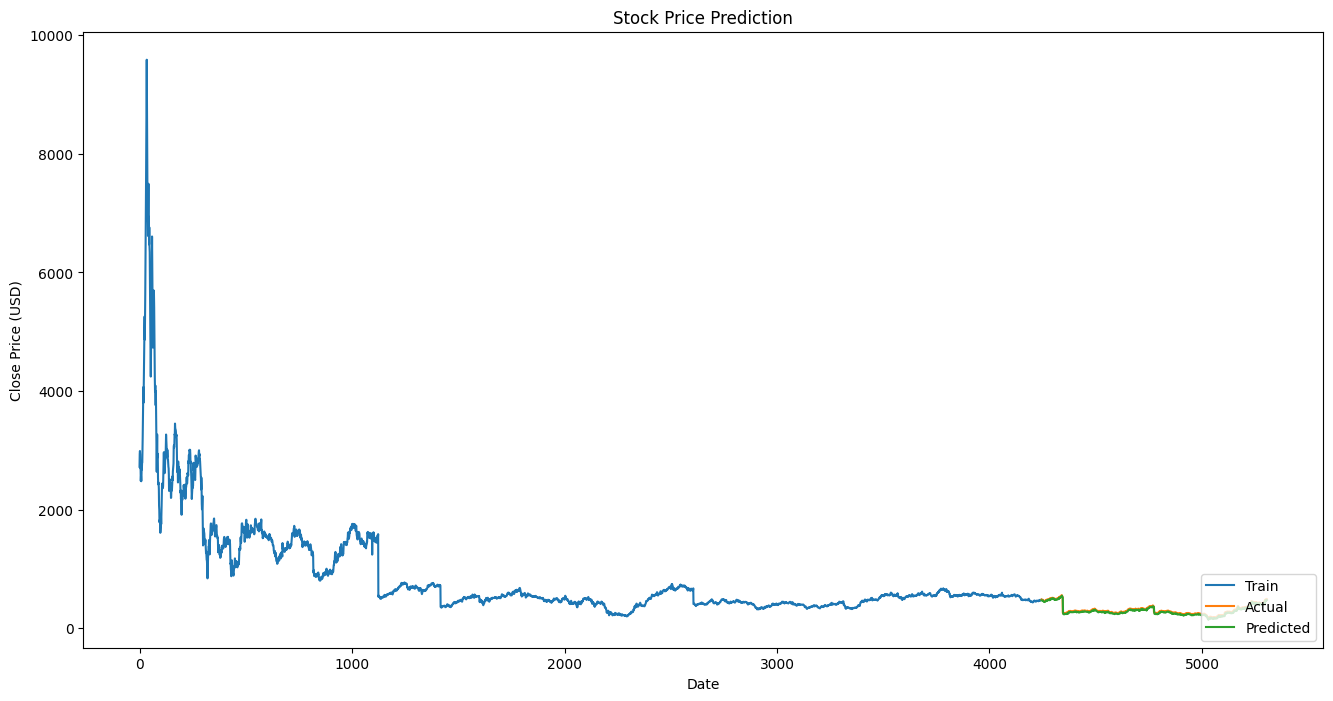

In [6]:
# Load the stock data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WIPRO.csv')

# Extracting the 'Close' column for prediction
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * 0.8))  # 80% of data for training

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Creating the training dataset
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

# LSTM requires data in a specific format
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the training data to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data to be 3-dimensional in the form [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

# Create the testing dataset
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

# Convert the testing data to numpy array
x_test = np.array(x_test)

# Reshape the data to be 3-dimensional in the form [samples, time steps, features]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print('Root Mean Squared Error:', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()
